# Medical Note entity extraction and Node & Edge generations 

Data Source---https://www.kaggle.com/c/medical-notes/data

In [149]:
import pandas as pd 
import itertools
import numpy as np 
import datetime
from IPython.display import display

import matplotlib.pyplot as plt 
import re
import string

import nltk

from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns
import plotly.express as px

sns.set(style="darkgrid")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN

from spacy.matcher import Matcher 
from spacy.tokens import Span 


from tqdm import tqdm
import re
import networkx as nx

import gensim
import spacy
import os
import gc
import glob
print('The test time: ',datetime.datetime.now())

The test time:  2021-03-03 14:02:40.618920


In [150]:
df_list=[]
def read_text_file(): 
    path=os.getcwd()
    for file in os.listdir(): 
        # Check whether file is in text format or not 
        if file.endswith(".txt"): 
            file_path = f"{path}/{file}"
            with open(file_path, 'r', encoding='latin1') as f: 
                read_text=f.read()
                df_list.append(read_text)

In [151]:
read_text_file()

In [152]:
df=pd.DataFrame(df_list,columns=['medical_note'])
df

,medical_note
0,\n\n\n\n\n<B>EXAM:</B> CT Abdomen & Pelvis W&...
1,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSIS:</B> Prot...
2,\n\n\n\n\n<B>PROCEDURE:</B> Upper endoscopy.\...
3,\n\n\n\n\n<B>REASON FOR CONSULTATION: </B> Pos...
4,\n\n\n\n\n<B>PREOPERATIVE DIAGNOSES:</B>\n1. ...
...,...
152,\n\n\n\n\n<B>PREPROCEDURE DIAGNOSIS:</B> Chan...
153,\n\n\n\n\n<B>PROCEDURE:</B> Upper endoscopy wi...
154,\n\n\n\n\n<B><B>CHIEF COMPLAINT:</B></B> Stoma...
155,\n\n\n\n\n<B>EXAM: </B> CT abdomen without con...


In [153]:
df.isnull().sum().sum()

0

## 1. Clean the text

In [155]:
p_remove=re.compile('(\n|<B>|</B>)') 
note=df.medical_note

i=0
for note_1 in note:
    note_1=p_remove.sub("",note_1)
    note[i]=note_1
    i=i+1

print('Total number of notes: ',len(note))

Total number of notes:  157


In [156]:
# convert to lower cases
to_lower=lambda x: x.lower()
note_lc=note.apply(to_lower)
note_lc

0      exam:  ct abdomen & pelvis w&wo contrast reaso...
1      preoperative diagnosis:  protein-calorie malnu...
2      procedure:  upper endoscopy.preoperative diagn...
3      reason for consultation:  possible free air un...
4      preoperative diagnoses:1.  gastroesophageal re...
                             ...                        
152    preprocedure diagnosis:  change in bowel funct...
153    procedure: upper endoscopy with foreign body r...
154    chief complaint: stomach pain for 2 weeks.hist...
155    exam:  ct abdomen without contrast and pelvis ...
156    preoperative diagnosis:  iron deficiency anemi...
Name: medical_note, Length: 157, dtype: object

In [157]:
note_clean=note_lc
note_clean[1]

'preoperative diagnosis:  protein-calorie malnutrition.postoperative diagnosis:  protein-calorie malnutrition.procedure performed: percutaneous endoscopic gastrostomy (peg) tube.anesthesia:  conscious sedation per anesthesia.specimen:  none.complications:  none.history:  the patient is a 73-year-old male who was admitted to the hospital with some mentation changes.  he was unable to sustain enough caloric intake and had markedly decreased albumin stores.  after discussion with the patient and the son, they agreed to place a peg tube for nutritional supplementation.procedure:  after informed consent was obtained, the patient was brought to the endoscopy suite.  he was placed in the supine position and was given iv sedation by the anesthesia department.  an egd was performed from above by dr. x.  the stomach was transilluminated and an optimal position for the peg tube was identified using the single poke method.  the skin was infiltrated with local and the needle and sheath were inserte

## 2. NLP 

In [12]:
import scispacy
import spacy

import en_core_sci_sm   #The model we are going to use
import en_core_sci_scibert
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

## 2.1 Dependency parsing

In [13]:
nlp = spacy.load("en_core_sci_sm") 

In [14]:
text=note_clean[0]
sents=[]
doc = nlp(text)
for sent in doc.sents:
    sent=sent.text
    sents.append(sent)

In [15]:
print('len of sents is: ', len(sents))

len of sents is:  31


In [16]:
chunks=[]

chunk_dep=[]
chunk_root=[]
for sent in sents:
    doc=nlp(sent)

    for chunk in doc.noun_chunks:
        chunks.append(chunk.root.text),
        chunk_dep.append(chunk.root.dep_)
        chunk_root.append(chunk.root.head.text)

chunk_d_root=pd.DataFrame(np.column_stack([chunks,chunk_dep,chunk_root]),columns=['noun','dep','root'])


In [17]:
chunk_d_root

,noun,dep,root
0,exam,ROOT,exam
1,abdomen,appos,exam
2,reason,conj,abdomen
3,repair,appos,abdomen
4,technique,nsubjpass,performed
5,scanning,nsubjpass,performed
6,enhancement,dobj,utilizing
7,contrast,nsubjpass,utilized
8,comparison,nsubjpass,made
9,change,attr,been


In [20]:
def create_table(nlp,document):
    doc=nlp(document)
    values={}
    for x in doc.ents:
        values[x.text]=x.label_
    return values


## 2.2 Entities Extractions 

In [21]:
#NER specific models
import en_ner_craft_md
import en_ner_bc5cdr_md
import en_ner_jnlpba_md
import en_ner_bionlp13cg_md

In [22]:
nlp_cr = en_ner_craft_md.load()
nlp_bc = en_ner_bc5cdr_md.load()
nlp_bi = en_ner_bionlp13cg_md.load()
nlp_jn = en_ner_jnlpba_md.load()

In [23]:
doc=nlp(text)

In [24]:
def add_bc(abstractList, doiList):
    i = 0
    table= {"doi":[], "Entity":[], "Class":[]}
    for doc in nlp_bc.pipe(abstractList):
        doi = doiList[i]
        for x in doc.ents:
          table["doi"].append(doi)
          table["Entity"].append(x.text)
          table["Class"].append(x.label_)
        i +=1
    return table

In [25]:
#Create lists
doiList = df.index.tolist()
abstractList = note_clean

#Add all entity value pairs to table (run one at a time, each ones takes ~20 min)


table = add_bc(abstractList, doiList)



#Turn table into an exportable CSV file (returns normalized file of entity/value pairs)
trans_df = pd.DataFrame(table)
trans_df.to_csv ("Entity_all.csv", index=False)

In [26]:
disease_df=trans_df.loc[trans_df.Class=='DISEASE']

In [27]:
disease_lst=list(disease_df.Entity.unique())

In [28]:
len(disease_lst)

737

In [29]:
disease_count=disease_df['Entity'].value_counts()

In [30]:
disease_count=pd.DataFrame(disease_count)
disease_count=disease_count.loc[disease_count.Entity>4]

In [31]:
disease_frq=disease_count.Entity

In [32]:
freq_disease=list(disease_count.index)
len(freq_disease)

86

<BarContainer object of 7 artists>

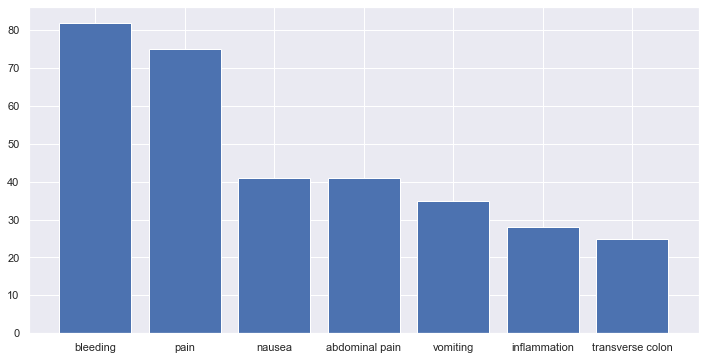

In [33]:
fig,ax= plt.subplots(figsize=(12,6))
ax.bar(freq_disease[:7],disease_frq[:7])


In [34]:
def add_bi(abstractList, doiList):
    i = 0
    table= {"doi":[], "Entity":[], "Class":[]}
    for doc in nlp_bi.pipe(abstractList):
        doi = doiList[i]
        for x in doc.ents:
          table["doi"].append(doi)
          table["Entity"].append(x.text)
          table["Class"].append(x.label_)
        i +=1
    return table

In [35]:
#Create lists
doiList = df.index.tolist()
abstractList = note_clean


table = add_bi(abstractList, doiList)



#Turn table into an exportable CSV file (returns normalized file of entity/value pairs)
trans_df = pd.DataFrame(table)
trans_df

,doi,Entity,Class
0,0,abdomen,ORGAN
1,0,pelvis w&wo,CANCER
2,0,graft,TISSUE
3,0,abdomen,ORGAN
4,0,pelvis,ORGAN
...,...,...,...
6273,156,sigmoid colon,TISSUE
6274,156,inflammation,PATHOLOGICAL_FORMATION
6275,156,anorectal,ORGAN
6276,156,patient,ORGANISM


In [36]:
ent_cnt=trans_df['Entity'].value_counts()


ent_cnt=pd.DataFrame(ent_cnt)
ent_cnt=ent_cnt.loc[ent_cnt.Entity>4]
ent_cnt

,Entity
patient,712
abdomen,140
stomach,120
colon,106
bowel,105
...,...
legs,5
cardiac,5
fentanyl,5
caudad,5


## 2.3 Extract target entities from each sentence and convert it into df

In [37]:
ent_list=list(ent_cnt.index)

In [38]:
sents=[]
for text in note_clean:
    doc=nlp(text)
    for sent in doc.sents:
        sents.append(sent)
        
ent_pair=[]
for sent in sents:
    doc=nlp(sent.text)
    ent_pair_s=[]
    for ent in doc.ents:
        ent=ent.text
        if ent in ent_list:
            ent_pair_s.append(ent)
            ent_pair.append(ent_pair_s)
        else:
            pass
    

In [39]:
ent_pair_df=pd.DataFrame(ent_pair)

In [40]:
ent_pair_df

,0,1,2,3,4,5,6,7,8
0,abdomen,pelvis,None,None,None,None,None,None,None
1,abdomen,pelvis,None,None,None,None,None,None,None
2,abdomen,pelvis,None,None,None,None,None,None,None
3,abdomen,pelvis,None,None,None,None,None,None,None
4,rectal,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
3037,lesions,None,None,None,None,None,None,None,None
3038,sigmoid,colon,inflammation,None,None,None,None,None,None
3039,sigmoid,colon,inflammation,None,None,None,None,None,None
3040,sigmoid,colon,inflammation,None,None,None,None,None,None


## 3. Generate 'edges' and 'nodes' dataframe and store it as csv

In [41]:
pairs=[]
for i in range(len(ent_pair_df)):
    base=ent_pair_df.loc[i,0]
    for j in range(len(ent_pair_df.columns)):
        if (ent_pair_df.loc[i,j]!=None) and (ent_pair_df.loc[i,j]!=base):
            ent=ent_pair_df.loc[i,j]
            pair=[base,ent]
            pairs.append(pair)

            
    

In [100]:
edges=pd.DataFrame(pairs,columns=['source','target'])
edges

,source,target
0,abdomen,pelvis
1,abdomen,pelvis
2,abdomen,pelvis
3,abdomen,pelvis
4,abdomen,pelvis
...,...,...
3371,sigmoid,inflammation
3372,sigmoid,colon
3373,sigmoid,inflammation
3374,sigmoid,colon


In [64]:
s_count=edges['source'].value_counts()
t_count=edges['target'].value_counts()

In [96]:
node_names=[]
node_counts=[]
for node_s in s_count.index:
    for node_t in t_count.index:
        if node_s==node_t:
            node_count=s_count[node_s]+t_count[node_s]
            node_counts.append(node_count)
            node_names.append(node_s)
        else:
            pass
    if node_s not in node_names:
        node_names.append(node_s)
        node_counts.append(s_count[node_s])
for node_t in t_count.index:
    if node_t not in node_names:
        node_names.append(node_t)
        node_counts.append(t_count[node_t])

In [146]:
nodes= pd.DataFrame(np.column_stack([node_names, node_counts,node_classes]), 
                               columns=['name', 'nodesize','group'])

In [147]:
nodes.to_csv('node.csv',index=False)
edges.to_csv('edge.csv',index=False)

In [141]:
trans_df

,doi,Entity,Class
0,0,abdomen,ORGAN
1,0,pelvis w&wo,CANCER
2,0,graft,TISSUE
3,0,abdomen,ORGAN
4,0,pelvis,ORGAN
...,...,...,...
6273,156,sigmoid colon,TISSUE
6274,156,inflammation,PATHOLOGICAL_FORMATION
6275,156,anorectal,ORGAN
6276,156,patient,ORGANISM
